# Dynamical Mean Field Theory of Generalized Lotka Volterra

In [18]:
#Libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
from scipy.integrate import odeint
import pandas as pd
import math

#seed
np.random.seed(2081409)

#path to save data and plots
path_to_data = 'placeholder/' 
path_to_results = 'placeholder/'

# boolean to control plot, prints and save
PLOT = True
PRINT = True
SAVE = False

In [2]:
#settings for plots

#tableau for plots
plt.style.use('tableau-colorblind10')

plt.rcParams["figure.autolayout"] = True

plt.rcParams['font.size'] = 16        # Default font size for text
plt.rcParams['axes.titlesize'] = 16   # Font size for axes titles
plt.rcParams['axes.labelsize'] = 16   # Font size for x and y labels
plt.rcParams['xtick.labelsize'] = 16  # Font size for x tick labels
plt.rcParams['ytick.labelsize'] = 16  # Font size for y tick labels

#### Function $J(x)$ that enters in the interaction terms and its derivative $\frac{dJ}{dx}$

In [3]:
def J(x, K):
    '''
        Input:
            x --> a float or a np.array
            K --> the parameter K of the function
        Output:
            A float or a np.array with the function evaluated in x
    '''
    return x/(1+K*x)

def dJdx(x, K):
    '''
        Input:
            x --> a float or a np.array
            K --> the parameter K of the function
        Output:
            A float or a np.array with the derivative of the function J evaluated in x
    '''
    return 1/(1+K*x)**2

## GLV with SI ODE

In [4]:
def GLV(y, t, alpha, K):
    '''
        Definition of the function to pass as parameter to odeint() of scipy.integrate for itegrating ODE
    '''
    dydt = np.zeros_like(y)
    for i in range(N):
        dydt[i] = y[i]*(1-y[i]+np.dot(alpha[i, :], J(y, K)))
        
    return dydt

In [5]:
def ODE_integration_GLV(N, mu, sigma, gamma, K, initial_condition = 'uniform', M = 1, B = 1, PLOT = True, PRINT = True, SAVE = False):
    
    #covariance matrix and mean for sampling
    cov = [[1, gamma], [gamma, 1]]
    mean = [0,0]
    
    #for-cycle on different sampling of coefficients
    for b in range(B): 
        
        alpha = np.zeros([N, N]) #matrix of interactions
        
        #sampling of interactions
        for i in range(N):
            for j in range(i, N):
                z = np.random.multivariate_normal(mean, cov)
                alpha[i, j] = mu/N+sigma/np.sqrt(N)*z[0]
                alpha[j, i] = mu/N+sigma/np.sqrt(N)*z[1]

        
        #for-cycle on different initial conditions
        for m in range(M):  
            
            #Sampling random initial conditions
            if type(initial_condition)!= str:
                 y0 = initial_condition
        
            elif initial_condition == 'uniform':
                y0 = np.random.uniform(0, 1, N)
           
            if PRINT :
                print('Iteration:', b*M+(m+1), '/', M*B)
            
            sim_GLV = odeint(GLV, y0, t, args=(alpha, K)) #integration
            
            
            phi = np.sum(sim_GLV[-1, :]>0)/N #fraction of survived species
            extincted = 1 - phi #fraction of extincted species
            
            if PLOT :
                plt.figure()
                for i in range(N):
                    plt.plot(t, sim_GLV[:, i])
                    plt.xlabel('Time')
                    plt.ylabel('Populations')
                    
                plt.title('N_{}_mu_{}_sigma_{}_gamma_{}_K_{}_phi_{}_b_{}_m_{}'.format(N, mu, sigma, gamma, K, phi, b, m))
                
                if SAVE :
                    plt.savefig(path_to_results+'N_{}_mu_{}_sigma_{}_gamma_{}_K_{}_phi_{}_b_{}_m_{}'.format(N, mu, sigma, gamma, K, phi, b, m), format = 'png')
    
    return sim_GLV  #useful only for M=1 and B=1

#### Example of integration of ODE

In [7]:
#Parameters of the model
mu = 0 # average interaction strength
sigma = 2 # standard deviation of interactions
gamma = 1 # correlations: structure the interactions
K = 1 #1/capacity of interactions

#Parameters of integration 
t_max = 50  #maximum time
dt = 0.1    #time step
N_steps = int(t_max/dt)  
t = np.linspace(0, t_max, N_steps) #time


N = 200 #number of species
M = 2 #number of repetition with different initial conditions
B = 3 #numer of repetition with different sampling of interaction coefficients

Iteration: 1 / 1


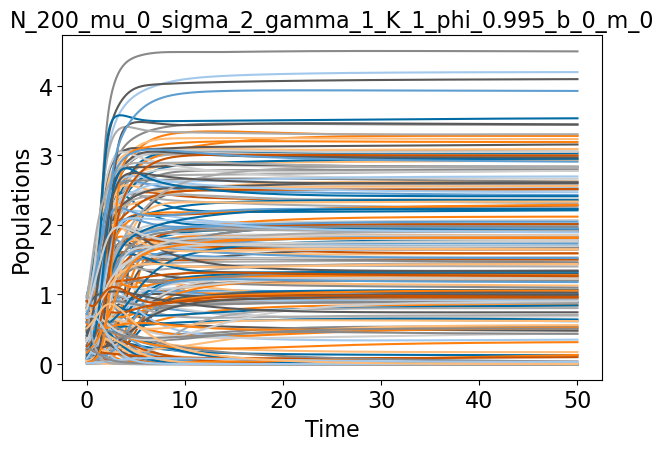

In [8]:
sim_GLV = ODE_integration_GLV(N, mu, sigma, gamma, K)

## DMFT Numerical Integration

#### Functions to solve numerically DMFT

In [6]:
#Step 1: Initial guesses for G(t,t'), C(t't'), Q(t); Sampling the gaussian path

#NB: the algortihm converges for every initial condition
def init_sampling(N, N_steps, K):
    '''
    Input:
        N = number of realizations
        N_steps = # of steps of integration
    Output:
        [Q_init, C_init, G_init] = initial guess for the array of Q, and matrices C, G
    '''
    #For Q we sample a random vector of populations x~U[0,1] and compute J(x)
    Q_init = J(np.random.random(N_steps), K) 
    #For C we choose the identity matrix (C needs to be symmetric)
    C_init = np.diag(np.ones(N_steps)) 
    #For G we choose a lower-diagonal matrix (for causality)
    G_init = np.tri(N_steps, k=0)*0.01 #(chosen empirically)

    return [Q_init, C_init, G_init]


#Sampling the gaussian path
def gaussian_path(N, N_steps, C, mean = 0):
    '''
    Input:
        N = number of trajectories
        N_steps = length of the trajectory
        C = correlation to sample from(covariance matrix)
    Output:
        eta = matrix N_steps x N of gaussian noise
    '''
    eta = np.zeros([N_steps, N])
    
    if mean == 0: #default case
        mean = np.zeros([N_steps])
        
    for i in range(N):
        path = np.random.multivariate_normal(mean, C)
        eta[:, i] = path
    
    return eta


#Step 2: Numerical integration of the trajectory

#Initial conditions
def init_trajectories(N, N_steps, initial_condition = 'uniform'):
    '''
         Initialize the trajectories of DMFT
         Input:
            N = int # of realizations
            N_steps = int # of steps of integration
            initial_condition = 1d array of len N or string specifing the wanted initialization
         Output:
            x = 2d array of shape [N_steps, N] with x[0, :] initialized    
    '''
    x = np.zeros([N_steps, N]) #creating a matrix to store the trajectories
    
    if type(initial_condition)!= str:
        x[0, :] = initial_condition
        
    elif initial_condition == 'uniform' : #default initial conditions
        x[0, :] = np.random.random(N) #initial conditions of the populations (U[0,1])   
    
    return x
    
    
#Integrator
def euler_integrator_DMFT_GLV(x, N_steps, dt, mu, sigma, gamma, K, Q, G, eta):
    '''
        Euler integrator for the trajectories
        Input:
            x = the initialized trajectories
            dt = time step
            N_steps = # of steps
            mu, sigma, gamma, K = parameters of the model
            Q, G = the last updated functions
            eta = gaussian path
        Output:
            x = the integrated trajectories
    '''
    for i in range(1, N_steps):
        temp1 = 1-x[i-1, :]
        if gamma==0:
            temp2=0
        else:
            temp2 = gamma*sigma**2*np.sum(dt*G[i,:i, np.newaxis]*J(x[:i, :], K), axis = 0)
        temp3 = mu*Q[i-1]+eta[i-1, :]
                
        x[i, :] = x[i-1, :] + dt*x[i-1, :]*(temp1+temp2+temp3)
        
    return x


#Step 3: computing the new observables

def integrate_G(x, N, N_steps, dt, sigma, gamma, K, Q, G_old, eta) :

    '''
        Compute the new G matrix with integration method
        Input:
            G_old = the old matrix
        Output:
            G_new = the new G matrix
    '''

    #Temporarely adding a dimension, along which compute the average
    G_temp = np.zeros([N_steps, N_steps, N])
    
    
    for t2 in range(N_steps-1):
        
        G_temp[t2,t2,:] = dJdx(x[t2, :], K)*x[t2, :]
        
        for t1 in range(t2, N_steps-1):
            
            temp1 = -2*J(x[t1, :], K)*G_temp[t1, t2, :]*K
            
            temp2 = 1-x[t1, :]+gamma*sigma**2*np.sum(dt*G_temp[t1, :t1, :]*J(x[:t1, :], K))+mu*Q[t1]+eta[t1, :]
            
            temp3 = G_temp[t1, t2, :]*(1-2*x[t1, :]+mu*Q[t1]+eta[t1,:]+gamma*sigma**2*np.sum(dt*G_temp[t1, :t1, :]*J(x[:t1, :], K)))
            
            temp4 = dJdx(x[t1,:], K)*x[t1,:]*gamma*sigma**2*np.sum(dt*G_temp[t1, :t1, :]*G_temp[:t1, t2, :])
            
            #euler integration of G
            G_temp[t1+1, t2, :] = G_temp[t1, t2, :] + dt*(temp1*temp2+temp3+temp4)
                        
    
    #averaging over realizations
    G_new = np.mean(G_temp, axis = 2)
    
    
    return G_new
    
    

#computing observables Q, C, G
def observables(x, N, N_steps, sigma, gamma, K, Q_old, C_old, G_old, eta, howG = 'Integrate'):
    
    '''
        Given the previous iteration trajectories and functions compute the new observables Q, C, G
        Input:
            usual x, N, N_steps; Q_old, C_old, G_old, sigma, gamma, eta
            howG = specify the method to compute G. By default is throught integration
        Output:
            [Q, C, G] = the new observables

    '''
    
    #average of interaction terms
    Q = np.mean(J(x, K), axis = 1)
    
    #correlation between interaction terms
    C = np.zeros([N_steps, N_steps])
    for k in range(N_steps):
        for l in range(k+1):
            C[k, l] = np.mean(J(x[k,:], K)*J(x[l,:], K)) 
            C[l, k] = C[k, l]
    
    #G is needed only if gamma is different from zero
    if gamma == 0:
        G =  G_old
    else:
        #method base on Novikov theorem
        if howG == 'Novikov':
            C_inv = np.linalg.inv(C_old) #computationally expensive
            G = np.zeros([N_steps, N_steps])
            for k in range(N_steps):
                for l in range(k+1):
                    G[k, l] = 1/N*np.sum(1/sigma*J(x[k, :], K)*dt*np.dot(C_inv, eta)[l, :]) #Novikov result 
        elif howG == 'Integrate':
            G = integrate_G(x, N, N_steps, dt, sigma, gamma, K, Q, G_old, eta)

    return [Q, C, G]

#softly adjourning the functions
def soft_update(old, new, a = 0.3):
    '''
       Given the old and new observables compute the next iteration observable softly
        Input:
            [Q_old, C_old, G_old] = old observables
            [Q_new, C_new, G_new] = new observables
            a = softly injection parameter, set to 0.3 by default
        Output:
            [Q_up, C_up, G_up] = updated observables
            
    '''
    updated = []
    updated.append((1-a)*old[0] + a*new[0])
    updated.append((1-a)*old[1] + a*new[1])
    updated.append((1-a)*old[2] + a*new[2])
    
    return updated


#Step 4: repeat till convergence
def DMFT_GLV(N, N_steps, dt,  mu, sigma, gamma, K, initial_condition = 'uniform', N_max = 30, a = 0.3, threshold = 10**(-5), PRINT = True):
    
    '''
        Solve DMFT for GLV
        
        Input:
            N = # of realizations
            dt, N_steps = parameters of integration
            mu, sigma, gamma, K = parameters of the model
            initial_condintion (opt) = by default sampled randomly
            N_max, a, threshold = parameters of numerical implementation of DMFT
            
        Output:
            [x, old, convergence] = the trajectories x, the final estimated observables old and
                                    the story of the observables with number of iterations
    '''
    
    #variables to store the convergence of the observables
    Q_story = np.zeros(N_max)
    C_story = np.zeros(N_max)
    G_story = np.zeros(N_max)
    
    #Step 1
    old = init_sampling(N, N_steps, K)
       
    for n in range(N_max):
        
        #Step 1
        Q = old[0]
        C = old[1]
        G = old[2]

        eta = gaussian_path(N, N_steps, C)

        #Step 2
        x = init_trajectories(N, N_steps, initial_condition)

        x = euler_integrator_DMFT_GLV(x, N_steps, dt, mu, sigma, gamma, K, Q, G, eta)
        
        #Step 3
        new = observables(x, N, N_steps, sigma, gamma, K, Q, C, G, eta, howG = 'Integrate')

        updated = soft_update(old, new, a)
        
        
        #Computing error
        err_Q = np.linalg.norm(updated[0]-old[0])
        err_C = np.linalg.norm(updated[1]-old[1])
        err_G = np.linalg.norm(updated[2]-old[2])
        
        #Controlling convergence
        if err_Q < threshold and err_C <threshold and err_G <threshold:
            old = updated
            break
                
        #Update
        old = updated
        
        #Print iteration and errors
        if PRINT:
            print(n,'/', N_max, ':', err_Q, err_C, err_G)
        
        #Adjurn history of convergence
        Q_story[n] = Q[-1]
        C_story[n] = C[-1, -1]
        G_story[n] = np.sum(dt*G[-1, :])
      
    convergence = [Q_story, C_story, G_story]
    
    return x, old, convergence


#### Example of integration of DMFT

In [10]:
mu = 0 # average interaction strength
sigma = 3 # standard deviation of interactions
gamma = 0 # correlations: structure the interactions
K = 1 #1/capacity of interactions

#Parameters of integration
t_max = 20
dt = 0.1
N_steps = int(t_max/dt)
t = np.linspace(0, t_max, N_steps) #time

N = 100 #number of species

#Parameters for DMFT solution
N_max = 30
a = 0.3
threshold = 10**-5

In [11]:
sim_DMFT_GLV, functions, convergence = DMFT_GLV(N, N_steps, dt,  mu, sigma, gamma, K)

0 / 30 : 0.9417844791424247 13.421619585087171 2.459394992999531e-16
1 / 30 : 0.6527780601716838 9.451343895344678 0.0
2 / 30 : 0.44758173625562253 6.583582318688696 0.0
3 / 30 : 0.33205505712505295 5.113696734518957 0.0
4 / 30 : 0.24298802975912762 3.916250210456681 0.0
5 / 30 : 0.19664730610164177 3.02567169523319 0.0
6 / 30 : 0.07024627432811685 0.9408666600027584 0.0
7 / 30 : 0.06797220016763915 1.1803457113994749 0.0
8 / 30 : 0.0365995041870557 0.5883530216836405 0.0
9 / 30 : 0.0713373842384596 1.1034205040062757 0.0
10 / 30 : 0.046714323910428054 0.5969740166947687 0.0
11 / 30 : 0.05144399902564734 0.695131811454596 0.0
12 / 30 : 0.03881053214657184 0.2570712297253391 0.0
13 / 30 : 0.052588568590929356 0.4512842302884649 0.0
14 / 30 : 0.013897500831598962 0.18250431799224773 0.0
15 / 30 : 0.06595540699090306 0.6450355515387879 0.0
16 / 30 : 0.029485208339914772 0.1401748721874614 0.0
17 / 30 : 0.03329300106974183 0.21565512411595894 0.0
18 / 30 : 0.11769898690184269 1.47851841481

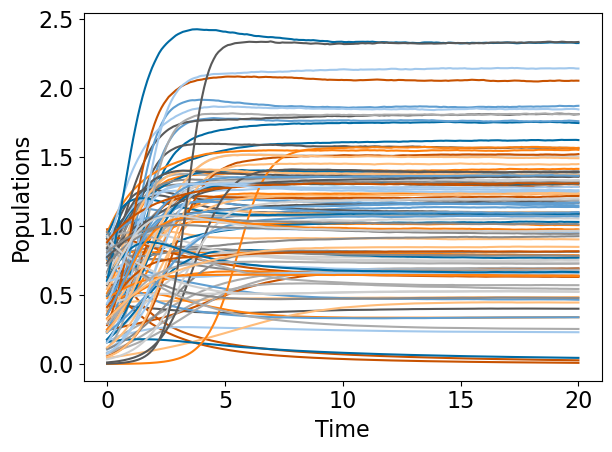

In [12]:
#Plot of DMFT of GLV integrated
for i in range(N):
    plt.plot(t, sim_DMFT_GLV[:, i])
    plt.xlabel('Time')
    plt.ylabel('Populations')
    
#plt.text(30, 1.42, r'$\mu=${}, $\sigma=${}, $\gamma=${}, $K=${}'.format(mu, sigma, gamma, K))

if SAVE:
    plt.savefig(path_to_results+'DMFT_integration_N_{}_mu_{}_sigma_{}_gamma_{}_K_{}'.format(N, mu, sigma, gamma, K), 
                format = 'png', bbox_inches='tight', pad_inches = 0.2)

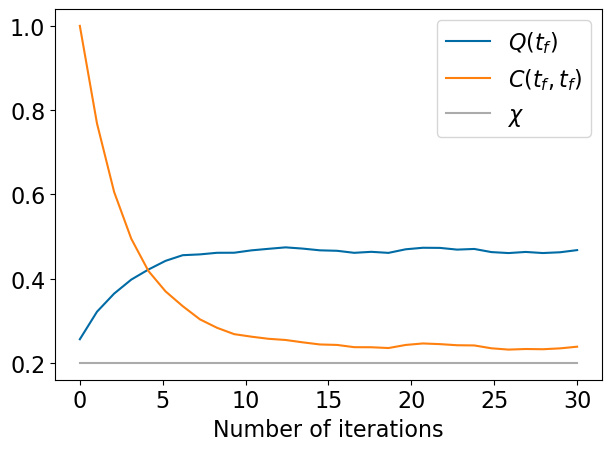

In [14]:
#Convergence of observables
n = np.linspace(0, N_max, N_max)
plt.plot(n, convergence[0], label = r'$Q(t_f)$')
plt.plot(n, convergence[1], label = r'$C(t_f, t_f)$')
plt.plot(n, convergence[2], label = r'$\chi$')

plt.xlabel('Number of iterations')
plt.legend()

if SAVE:
    plt.savefig(path_to_results+'Ex_obs_convergence_DMFT_N_{}_mu_{}_sigma_{}_gamma_{}_K_{}'.format(N, mu, sigma, gamma, K),
                format = 'png', bbox_inches='tight', pad_inches = 0.2)

## Stationary solution of DMFT

#### Functions to solve numerically the stationary solution of DMFT

In [7]:
def z_sampling(N):
    '''
        Sample N samples of the random variable z (gaussian)
        Input:
            N = # of samples
        Output:
            z = N normal samples N(0,1)
    '''
    z = np.random.normal(loc = 0, scale = 1, size = N)
    
    return z

def obs_sampling(N, K):
    '''
        Initialize Q, q, chi at random
        Input:
            N = # of realizations
        Output:
            [Q, q, chi] = initialized observables
    '''
    #average of J(x) with x randomly sampled
    Q = np.mean(J(np.random.random(N), K))
    #average same time correlation (stationary condition)
    q = np.mean(J(np.random.random(N), K)*J(np.random.random(N), K))
    #integral over time of G(t,t') = G(t-t')= G(tau); randomly sampled
    chi = np.random.random()
    
    return [Q, q, chi]

def x_stat(z_list, N, mu, sigma, gamma, K, Q, q, chi):
    '''
        Compute N realizations of x
        Input:
            z_list = sampled 
            N = # of realizations
            Q, q, chi = current observables
            mu, sigma, gamma, K = parameters of the model
        Output:
            x = np.array of shape (N,) of the samples x
    '''
    out=[]
    y = 1 - gamma*sigma**2*chi
    
    for z in z_list:

        eta = np.sqrt(q)*sigma*z
        t = 1+ mu*Q + eta 

        if t<0:
            x = 0
        else:
            x = -2*t/(K*t-y-np.sqrt((K*t-y)**2+4*K*t))

        out.append(x)
        
    return np.array(out)


def obs(x, z, N, mu, sigma, gamma, K, Q_old, q_old, chi_old):
    '''
        Compute the new observables
        Input:
            x = samples
            N = number of realizations
            K = parameter of the model
    '''
    #print(x)
    Q = np.mean(J(x, K))
    q = np.mean(J(x, K)**2)
    #print(Q, q)
    
    if gamma==0:
        chi = chi_old
        
    else: 
        
        y = 1-gamma*sigma**2*chi_old
        eta = np.sqrt(q)*sigma*z
        t = 1 + mu*Q + eta
        
        mask = t>0
        t = t[mask]
        
        sq = np.sqrt(4*K*t+(y-K*t)**2)
        temp = 2*t*(K-(4*K-2*K*(-K*t+y))/(2*sq))/(K*t-y-sq)**2-2/(K*t-y-sq)
        
        chi = np.sum(dJdx(x[mask], K)*temp)/N

    return [Q, q, chi]

#softly adjourning the functions
def soft_update(old, new, a = 0.3):
    '''
       Given the old and new observables compute the next iteration observable softly
        Input:
            [Q_old, C_old, G_old] = old observables
            [Q_new, C_new, G_new] = new observables
            a = softly injection parameter, set to 0.3 by default
        Output:
            [Q_up, C_up, G_up] = updated observables
            
    '''
    updated = []
    updated.append((1-a)*old[0] + a*new[0])
    updated.append((1-a)*old[1] + a*new[1])
    updated.append((1-a)*old[2] + a*new[2])
    
    return updated



#Step 4: repeat till convergence
def stat_DMFT_GLV(mu, sigma, gamma, K, N,  N_max = 30, a = 0.3, threshold = 10**(-5)):
    
    '''
        Solve stat DMFT for GLV
    '''
    
    #variables to store the convergence of the observables
    Q_story = np.zeros(N_max)
    q_story = np.zeros(N_max)
    chi_story = np.zeros(N_max)
    
    #Step 1
    old = obs_sampling(N, K)
        
    for n in range(N_max):

        Q = old[0]
        q = old[1]
        chi = old[2]
    
        #Step 1
        z = z_sampling(N)
    
        #Step 2
        x = x_stat(z, N, mu, sigma, gamma, K, Q, q, chi)
        
        #Step 3
        new = obs(x, z, N, mu, sigma, gamma, K, Q, q, chi)

        updated = soft_update(old, new, a)
        
        #compute error
        err_Q = np.linalg.norm(updated[0]-old[0])
        err_C = np.linalg.norm(updated[1]-old[1])
        err_G = np.linalg.norm(updated[2]-old[2])
        
        #check convergence
        if err_Q < threshold and err_C <threshold and err_G <threshold:
            old = updated
            break
        
        #update
        old = updated
        
        #saving history
        Q_story[n] = Q
        q_story[n] = q
        chi_story[n] = chi
        
    convergence = [Q_story, q_story, chi_story]
    
    return x, old, convergence

#### Example of solution of stationary DMFT

In [16]:
mu = 0.4# average interaction strength
sigma = 1.7 # standard deviation of interactions
gamma = 1 # correlations: structure the interactions
K = 1 #1/capacity of interactions

#Parameters of integration
t_max = 50
dt = 0.1
N_steps = int(t_max/dt)
t = np.linspace(0, t_max, N_steps) #time

N = 100 #umber of species

#Parameters for DMFT solution
N_max = 30
a = 0.3
threshold = 10**-5

In [17]:
sim_DMFT_stat, obs_stat, conv_stat = stat_DMFT_GLV(mu, sigma, gamma, K, N)

## Comparison between ODE, DMFT and stat DMFT

#### Parameters

In [47]:
mu = 2# average interaction strength
sigma = 0.5# standard deviation of interactions
gamma = -1 # correlations: structure the interactions
K = 1 #1/capacity of interactions

#Parameters of integration
t_max = 20
dt = 0.1
N_steps = int(t_max/dt)
t = np.linspace(0, t_max, N_steps) #time

N = 200 #number of species

#Parameters for DMFT solution
N_max = 30
a = 0.3
threshold = 10**-5

#### Inital conditions and solutions

GLV ODE integration
Iteration: 1 / 1
DMFT integration
0 / 30 : 1.3220961390234625 20.72002318343128 2.0375014907401208
1 / 30 : 1.0141044294579447 16.266047321331683 1.3486903498344975
2 / 30 : 0.7902557348618113 12.958436070973764 0.859179296044554
3 / 30 : 0.5899714327787325 9.808641211905845 0.5669877024787813
4 / 30 : 0.41300445071757896 6.883032225045217 0.41606838746871927
5 / 30 : 0.35966313283171814 6.20096473427531 0.19904524428264392
6 / 30 : 0.2696805115829004 4.662478483817392 0.14184160974197724
7 / 30 : 0.20708205937752133 3.5927108042110603 0.09094563427095481
8 / 30 : 0.14426623308684172 2.5811921280908705 0.057193834120639726
9 / 30 : 0.07719559006094567 1.318844149389639 0.08677563342270338
10 / 30 : 0.033981433331239694 0.5961875902204427 0.07674936768517047
11 / 30 : 0.0336564012142116 0.5818455148723958 0.05009867978250101
12 / 30 : 0.06102934931812439 1.0959528929034263 0.057428716059977875
13 / 30 : 0.0525551680630883 0.9503562474414723 0.05167411691918415
14 / 3

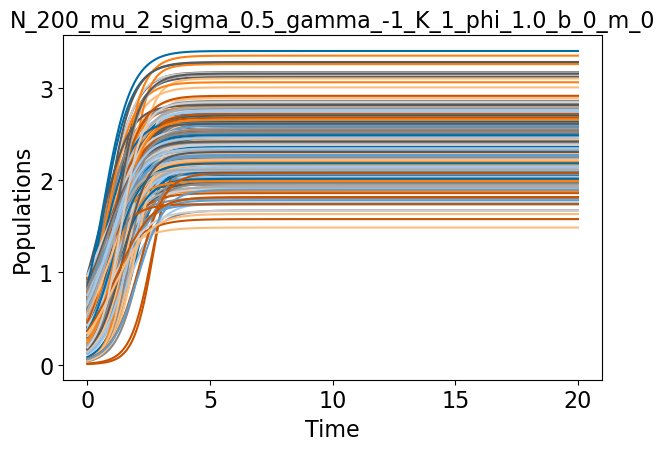

In [48]:
y0 = np.random.uniform(0, 1, N)

print('GLV ODE integration')
sim_GLV = ODE_integration_GLV(N, mu, sigma, gamma, K, y0)
print('DMFT integration')
sim_DMFT_GLV, functions, convergence = DMFT_GLV(N, N_steps, dt,  mu, sigma, gamma, K, y0)
print('Stationary DMFT integration')
sim_DMFT_stat, obs_stat, conv_stat = stat_DMFT_GLV(mu, sigma, gamma, K, N)

#### Comparison of results

In [49]:
SAVE = True

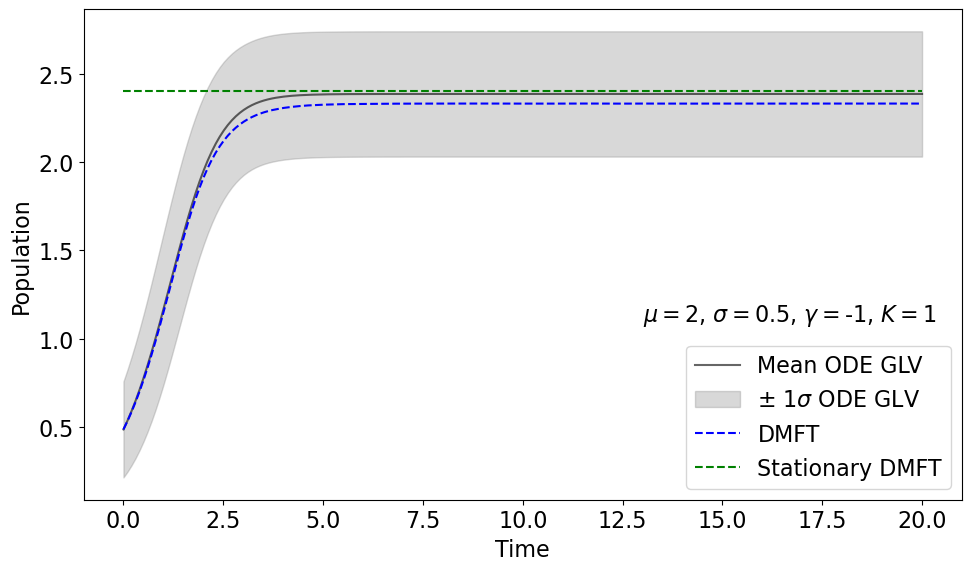

In [50]:
# GLV ODE
plt.figure(figsize=(10, 6))
plt.plot(t, np.mean(sim_GLV, axis=1), color='black', alpha = 0.6, label = 'Mean ODE GLV')
plt.fill_between(t, np.mean(sim_GLV, axis=1) - np.std(sim_GLV, axis = 1), 
                 np.mean(sim_GLV, axis=1) + np.std(sim_GLV, axis = 1),
                 color='grey', alpha=0.3, label=r'± $1 \sigma$ ODE GLV')

# DMFT of GLV
plt.plot(t, np.mean(sim_DMFT_GLV, axis=1), '--', color='b', label = 'DMFT')
#plt.plot(t, np.mean(sim_DMFT_GLV2, axis=1), '--', color='r', label = r'Phase 2, $\sigma=3$')

# Stat DMFT 
plt.plot(t, np.mean(sim_DMFT_stat)*np.ones(N_steps), '--', color='g', label = 'Stationary DMFT')


plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()

plt.text(13, 1.1, r'$\mu=${}, $\sigma=${}, $\gamma=${}, $K=${}'.format(mu, sigma, gamma, K))
if SAVE:
    plt.savefig(path_to_results+'Ex_comparison_DMFT_ODE_4_N_{}_mu_{}_sigma_{}_gamma_{}_K_{}'.format(N, mu, sigma, gamma, K),
                format = 'png', bbox_inches='tight', pad_inches = 0.1)

#### Comparison of convergence DMFT

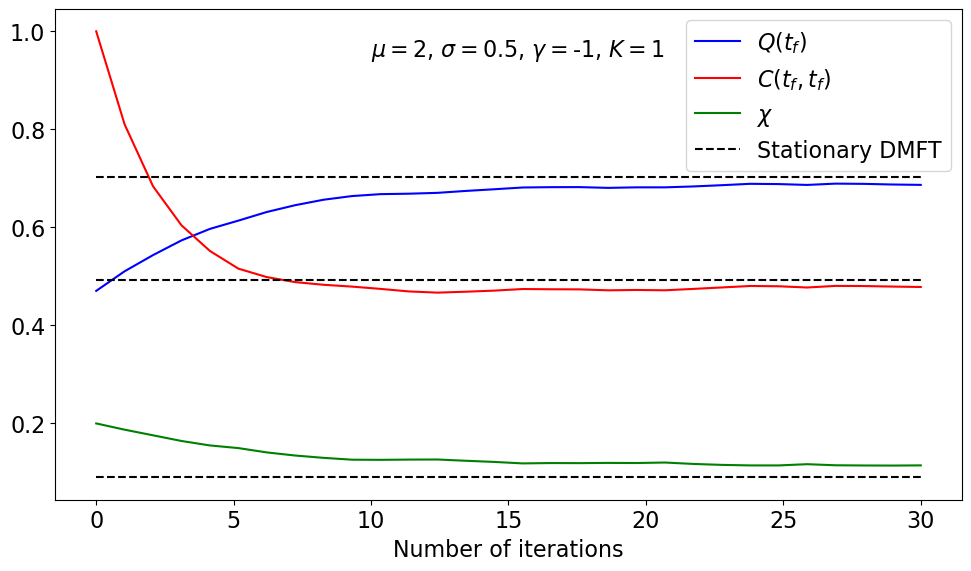

In [54]:
plt.figure(figsize=(10, 6))

#Convergence of observables
n = np.linspace(0, N_max, N_max)

#DMFT observables
plt.plot(n, convergence[0], label = r'$Q(t_f)$', color = 'blue')
plt.plot(n, convergence[1], label = r'$C(t_f, t_f)$', color = 'red')
plt.plot(n, convergence[2], label = r'$\chi$', color = 'green')

#Stat DMFT Observables
plt.plot(n, obs_stat[0]*np.ones(N_max), '--', color = 'black', label = 'Stationary DMFT')
plt.plot(n, obs_stat[1]*np.ones(N_max), '--', color = 'black')
plt.plot(n, obs_stat[2]*np.ones(N_max), '--', color = 'black')

plt.legend()
plt.xlabel('Number of iterations')
plt.text(10, 0.95, r'$\mu=${}, $\sigma=${}, $\gamma=${}, $K=${}'.format(mu, sigma, gamma, K))

if SAVE:
    plt.savefig(path_to_results+'Ex_convergence_comparison_DMFT_N_{}_mu_{}_sigma_{}_gamma_{}_K_{}'.format(N, mu, sigma, gamma, K),
               format = 'png', bbox_inches='tight', pad_inches = 0.1)